In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from torchvision import datasets, transforms
from PIL import Image
import torch
import torch.nn as nn 

IMG_DIR = "DATASET"
MODEL_PATH = 'DATASET/lettuce_npk.pth'

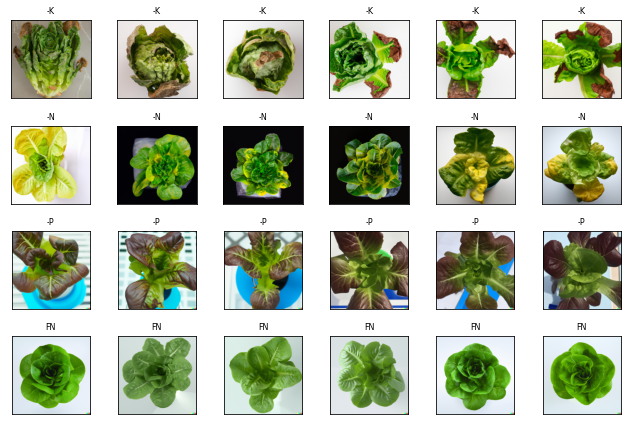

In [3]:
class_names = sorted(os.listdir(IMG_DIR))
nrows = len(class_names)
ncols = 6
plt.figure(figsize=(ncols*1.5, nrows*1.5))
for row in range(nrows):
    class_name = class_names[row]
    img_paths = [os.path.join(IMG_DIR, class_name, filename)
        for filename in os.listdir(os.path.join(IMG_DIR, class_name))]
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols + col + 1)
        img = plt.imread(img_paths[col])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(class_name, fontsize=8)
plt.tight_layout()
plt.show()

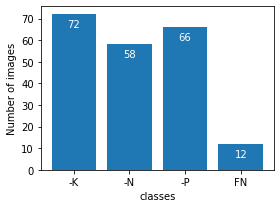

In [4]:
plt.figure(figsize=(4, 3))
class_counts = {class_name: len(os.listdir(os.path.join(IMG_DIR, class_name))) for class_name in class_names}

b = plt.bar(class_counts.keys(), class_counts.values())
plt.bar_label(b, class_counts.values(), color="white", padding=-15)
plt.ylabel("Number of images")
plt.xlabel("classes")
plt.tight_layout()
plt.show()

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
device

'cpu'

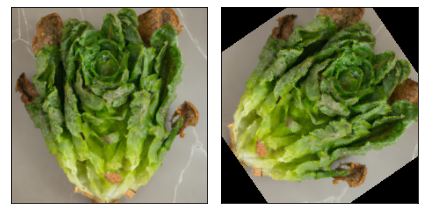

In [6]:
original_img = Image.open(os.path.join(IMG_DIR, "-K/k_1.png"))
resized_img = transforms.Resize((224, 224))(original_img)
transformed_img = transforms.RandomRotation(180)(resized_img)
imgs = [resized_img, transformed_img]

nrows = 1
ncols = len(imgs)
for col, img in enumerate(imgs):
  plt.subplot(nrows, ncols, col + 1)
  plt.imshow(np.asarray(img))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [7]:
from torchvision.models import resnet50, ResNet50_Weights
def get_resnet50():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 4),
        torch.nn.Softmax()
    )
    return model

In [8]:
def finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=None, checkpoint_epochs=5, max_epochs_without_imp=2):
  history = {
      "loss": {
          "train": [],
          "val": []
      },
      "accuracy": {
          "train": [],
          "val": []
      }
  }
  epochs_without_imp = 0
  for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}", end="\t-\t")

    model.train()  # put network in train mode for Dropout and Batch Normalization
    train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
    train_accuracy = torch.tensor(0., device=device)
    for X, y in train_dataloader:
      X = X.to(device)
      y = y.to(device)
      ypred = model(X)
      loss = loss_function(ypred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      with torch.no_grad():
        train_loss += loss*train_dataloader.batch_size
        train_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

    history["loss"]["train"].append(train_loss.item()/len(train_dataloader.dataset))
    history["accuracy"]["train"].append(train_accuracy.item()/len(train_dataloader.dataset))
    print(f"train loss: {history['loss']['train'][-1]:.2f}", end=", ")
    print(f"train acc: {history['accuracy']['train'][-1]:.2f}", end="\t-\t")

    if val_dataloader is not None:
      model.eval()
      val_loss = torch.tensor(0., device=device)
      val_accuracy = torch.tensor(0., device=device)
      with torch.no_grad():
        for X, y in val_dataloader:
          X = X.to(device)
          y = y.to(device)
          ypred = model(X)
          loss = loss_function(ypred, y)
          val_loss += loss * val_dataloader.batch_size
          val_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

      history["loss"]["val"].append(val_loss.item()/len(val_dataloader.dataset))
      history["accuracy"]["val"].append(val_accuracy.item()/len(val_dataloader.dataset))
      print(f"val loss: {history['loss']['val'][-1]:.2f}", end=", ")
      print(f"val acc: {history['accuracy']['val'][-1]:.2f}")
    # if epoch % checkpoint_epochs == 0:
    #   torch.save({
    #       'epoch': epoch,
    #       'state_dict': model.state_dict(),
    #       'optimizer': optimizer.state_dict(),
    #   }, './checkpoint.pth.tar')

    if epoch >= 2 and history["loss"]["train"][-1] >= history["loss"]["train"][-2]:
      epochs_without_imp += 1
    else:
      epochs_without_imp = 0
    if epochs_without_imp >= max_epochs_without_imp:
      break

  return model, history

In [9]:
transform = transforms.Compose([transforms.Resize(255, antialias=True),
                                transforms.CenterCrop(224),
                                transforms.RandomRotation(180),
                                transforms.ToTensor(),])
dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

In [10]:
# from time import time
# import multiprocessing as mp
# for num_workers in range(2, 16, 2):
#   train_loader = torch.utils.data.DataLoader(train_set,shuffle=True,num_workers=num_workers,batch_size=64,pin_memory=True)
#   start = time()
#   for epoch in range(1, 3):
#       for i, data in enumerate(train_loader, 0):
#           pass
#   end = time()
#   print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [11]:
class_counts = np.zeros(len(class_names))
train_labels = [int(label) for _, label in np.array(dataset.imgs)[train_set.indices]]
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3]), array([63, 45, 49, 10], dtype=int64))

In [12]:
# handling class imbalance in training data
from torch.utils.data import WeightedRandomSampler
train_labels = [label for _, label in np.array(dataset.imgs)[train_set.indices]]
class_counts = dict(zip(*np.unique(train_labels, return_counts=True)))
samples_weights = np.array([1/class_counts[label] for label in train_labels])
samples_weights = torch.from_numpy(samples_weights).double()
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=16, num_workers=4, pin_memory=True, sampler=sampler)

val_dataloader = torch.utils.data.DataLoader(
    val_set, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

model = get_resnet50().to(device)
weight_decay, epochs = 1e-4, 30
optimizer = torch.optim.Adam(
    [
        {"params": model.layer3.parameters(), "lr": 1e-4},
        {"params": model.layer4.parameters(), "lr": 1e-4},
        {"params": model.fc.parameters(), "lr": 1e-3},
    ],
    weight_decay=weight_decay
)
loss_function = torch.nn.CrossEntropyLoss()
model, history = finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=val_dataloader)

Epoch 1/30	-	

C:\Users\user\anaconda3\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


train loss: 1.39, train acc: 0.55	-	val loss: 2.05, val acc: 0.29
Epoch 2/30	-	train loss: 1.12, train acc: 0.77	-	val loss: 1.55, val acc: 0.86
Epoch 3/30	-	train loss: 0.91, train acc: 0.95	-	val loss: 1.37, val acc: 0.86
Epoch 4/30	-	train loss: 0.86, train acc: 0.95	-	val loss: 1.39, val acc: 0.90
Epoch 5/30	-	train loss: 0.84, train acc: 0.95	-	val loss: 1.18, val acc: 0.95
Epoch 6/30	-	train loss: 0.85, train acc: 0.96	-	val loss: 1.16, val acc: 1.00
Epoch 7/30	-	train loss: 0.83, train acc: 0.95	-	val loss: 1.31, val acc: 0.86
Epoch 8/30	-	train loss: 0.88, train acc: 0.90	-	val loss: 1.21, val acc: 0.95
Epoch 9/30	-	train loss: 0.85, train acc: 0.93	-	val loss: 1.22, val acc: 0.95
Epoch 10/30	-	train loss: 0.83, train acc: 0.96	-	val loss: 1.25, val acc: 0.90
Epoch 11/30	-	train loss: 0.81, train acc: 0.99	-	val loss: 1.22, val acc: 0.95
Epoch 12/30	-	train loss: 0.80, train acc: 0.98	-	val loss: 1.28, val acc: 0.90
Epoch 13/30	-	train loss: 0.81, train acc: 0.99	-	val loss: 1.

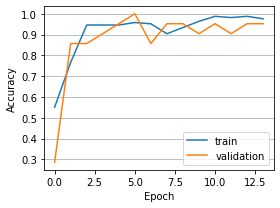

In [13]:
plt.figure(figsize=(4, 3))
plt.plot(history["accuracy"]["train"], label="train")
plt.plot(history["accuracy"]["val"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
torch.save(model, MODEL_PATH)

In [15]:
classes = os.listdir(IMG_DIR)
class_names = dict(zip(range(len(classes)), sorted(classes)))
class_names

{0: '-K', 1: '-N', 2: '-P', 3: 'FN', 4: 'lettuce_npk.pth'}

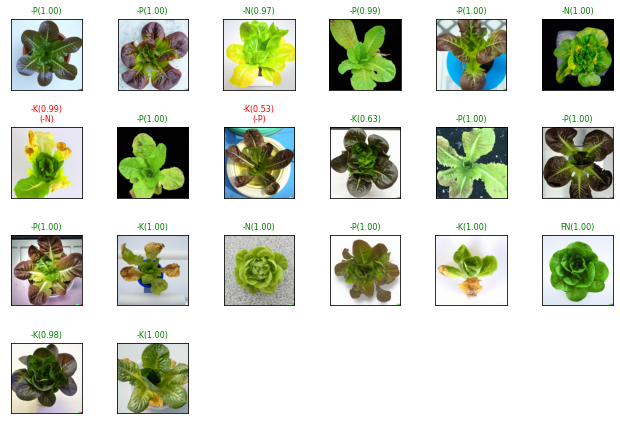

In [16]:
saved_model = torch.load(MODEL_PATH)
saved_model.eval()
with torch.no_grad():
    preds = saved_model(torch.stack([x for x, y in test_set]).to(device)).cpu().detach().numpy()
nrows = 4
ncols = 6
nimgs = nrows*ncols
plt.figure(figsize=(ncols*1.5, nrows*1.5))
i = 1
for img_path, label in np.array(dataset.imgs)[test_set.indices][:nimgs]:
    label = int(label)
    class_name = class_names[label]
    pred_label, confidence = np.argmax(preds[i-1]), max(preds[i-1])
    pred_class_name = class_names[pred_label]
    plt.subplot(nrows, ncols, i)
    img_number = col + 1
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(
        f"{pred_class_name}({confidence:.2f})" if pred_label==label else \
        f"{pred_class_name}({confidence:.2f})\n({class_name})",
        fontsize=8, color="green" if pred_label==label else "red"
    )
    i+=1
plt.tight_layout()
plt.show()

In [17]:
model = torch.load(MODEL_PATH)
def prediction(img):
    t = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(224, antialias=True)
    ])
    new_img = t(img)
    model.eval()
    with torch.no_grad():
        pred = model(torch.stack([new_img]).to(device)).cpu().detach().numpy()[0]
    class_label = np.argmax(pred)
    return class_names[np.argmax(pred)], pred[class_label]

i=0
img_path, _ = np.array(dataset.imgs)[test_set.indices][i]
print(img_path)
img = Image.open(img_path)
prediction(img)

DATASET\-P\p62.png


('-P', 0.9999988)